In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
import copy
import seaborn as sns
%matplotlib inline
%matplotlib inline

In [2]:
# Select a region (Amazon, Argentina)
# region = 'Amazon'
region = 'Argentina'

# Min number of MCS to plot
min_ntracks = 10

# MCS lifetime limits
lifetime_bounds = [2,60]

# Define region bounds
box_arg = [-68,-50,-40,-20]
box_amz = [-75,-40,-20,5]
# Months to include
months_amz = [1,2,3,4,10,11,12]
months_arg = [1,2,3,10,11,12]

# Lookup region based on input
bounds_dict = {'Argentina':box_arg, 'Amazon':box_amz}
months_dict = {'Argentina':months_arg, 'Amazon':months_amz}
bounds = bounds_dict[region]
months = months_dict[region]
print(f'{region} lat/lon bounds: {bounds}')
print(f'{region} months: {months}')

Argentina lat/lon bounds: [-68, -50, -40, -20]
Argentina months: [1, 2, 3, 10, 11, 12]


In [3]:
years = [2010, 2015, 2018]

# rootdir = '/global/cscratch1/sd/feng045/SAAG/mcs_tracking/3year_test_simulation/'
rootdir = '/global/project/projectdirs/m1657/zfeng/SAAG/mcs_tracking/3year_test_simulation/'
gpmfiles = []
wrffiles = []
for yy in years:
    gpmfiles = gpmfiles + sorted(glob.glob(f'{rootdir}GPM/stats/mcs_tracks_final_{yy}*.nc'))
    wrffiles = wrffiles + sorted(glob.glob(f'{rootdir}WRF/stats/mcs_tracks_final_{yy}*.nc'))
nyears_obs = len(gpmfiles)
nyears_wrf = len(wrffiles)
print(f'Number of years (OBS): {nyears_obs}')
print(f'Number of years (WRF): {nyears_wrf}')
figdir = f'/global/project/projectdirs/m1657/zfeng/SAAG/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of years (OBS): 3
Number of years (WRF): 3
/global/project/projectdirs/m1657/zfeng/SAAG/figures/


In [4]:
# Read OBS data
dsobs = xr.open_mfdataset(gpmfiles, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_obs = dsobs.dims['tracks']
dsobs['tracks'] = np.arange(0, ntracks_obs)
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
# dsobs

In [5]:
# Read wrf data
dsm1 = xr.open_mfdataset(wrffiles, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_wrf = dsm1.dims['tracks']
dsm1['tracks'] = np.arange(0, ntracks_wrf)
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']
# Convert longitudes from 0~360 to -180~+180
dsm1['meanlon'] = ((dsm1.meanlon - 180) % 360) - 180
dsm1['pf_lon'] = ((dsm1.pf_lon - 180) % 360) - 180
dsm1['pf_lon_centroid'] = ((dsm1.pf_lon_centroid - 180) % 360) - 180
dsm1['pf_lon_weightedcentroid'] = ((dsm1.pf_lon_weightedcentroid - 180) % 360) - 180
# dsm1

In [6]:
def find_track_in_region(times, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds, smonth_vals):
    
    # Get the track initiation month and location
    start_month = times.isel(times=0).dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)) & \
        (np.in1d(start_month, smonth_vals))
        # (start_month >= min(smonth_bounds)) & (start_month <= max(smonth_bounds))
    )[0]
    print('Number of MCS: ', len(mcsidx))
    return mcsidx

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
# start_month = dsobs.base_time.isel(times=0).dt.month
# smonth_vals = np.array([3, 4, 5])
# # np.intersect1d(start_month, smonth_vals)
# np.count_nonzero(np.in1d(start_month, smonth_vals))

In [8]:
time_res_obs = dsobs.attrs['time_resolution_hour']
time_res_m1 = dsm1.attrs['time_resolution_hour']
lifetime_obs = dsobs.track_duration * time_res_obs
lifetime_m1 = dsm1.track_duration * time_res_obs

# Subset MCS by region and lifetime
lon_bounds = [bounds[0],bounds[1]]
lat_bounds = [bounds[2],bounds[3]]
# lon_bounds, lat_bounds
mcsidx_obs = find_track_in_region(dsobs.base_time, dsobs.meanlon, dsobs.meanlat, lifetime_obs, lon_bounds, lat_bounds, lifetime_bounds, months)
mcsidx_m1 = find_track_in_region(dsm1.base_time, dsm1.meanlon, dsm1.meanlat, lifetime_m1, lon_bounds, lat_bounds, lifetime_bounds, months)

Number of MCS:  868


/global/common/software/m1867/python/py38/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in remainder
  return func(*(_execute_task(a, cache) for a in args))


Number of MCS:  724


(array([221., 159., 107.,   0.,   0.,   0.,   0.,   0.,   0.,  97., 284.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <BarContainer object of 11 artists>)

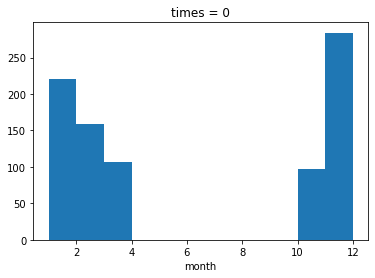

In [9]:
dsobs.base_time.dt.month.isel(tracks=mcsidx_obs, times=0).plot.hist(bins=np.arange(1,13,1))

In [10]:
stime_obs = dsobs.base_time.isel(times=0, tracks=mcsidx_obs)
syear_obs = stime_obs.dt.year
smonth_obs = stime_obs.dt.month
shour_obs = stime_obs.dt.hour

ccslifetime_obs = dsobs.track_duration.isel(tracks=mcsidx_obs) * time_res_obs
lifetime_obs = dsobs.pf_lifetime.isel(tracks=mcsidx_obs)
ccsarea_obs = dsobs.ccs_area.isel(tracks=mcsidx_obs)
ccsdiam_obs = 2 * np.sqrt(ccsarea_obs / np.pi)
mintb_obs = dsobs.corecold_mintb.isel(tracks=mcsidx_obs)
mcsstatus_obs = dsobs.mcs_status.isel(tracks=mcsidx_obs)
pflon_obs = dsobs.pf_lon.isel(tracks=mcsidx_obs, nmaxpf=0)
pflat_obs = dsobs.pf_lat.isel(tracks=mcsidx_obs, nmaxpf=0)
pfarea_obs = dsobs.pf_area.isel(tracks=mcsidx_obs, nmaxpf=0)
pfdiam_obs = 2 * np.sqrt(pfarea_obs / np.pi)
maxpfdiam_obs = pfdiam_obs.max(dim='times')
startstatus_obs = dsobs.start_status.isel(tracks=mcsidx_obs)
endstatus_obs = dsobs.end_status.isel(tracks=mcsidx_obs)

pfrainrate_obs = dsobs.pf_rainrate.isel(tracks=mcsidx_obs, nmaxpf=0)
pfaccumrain_obs = dsobs.pf_accumrain.isel(tracks=mcsidx_obs).sum(dim='nmaxpf')
maxpfrainrate_obs = pfrainrate_obs.max(dim='times')
meanpfrainrate_obs = pfrainrate_obs.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_obs = (dsobs.total_rain * pixel_radius_obs**2).isel(tracks=mcsidx_obs)
pfvolrainheavy_obs = (dsobs.total_heavyrain * pixel_radius_obs**2).isel(tracks=mcsidx_obs)

landfrac_obs = dsobs.pf_landfrac.isel(tracks=mcsidx_obs)
# init_landfrac_obs = landfrac_obs.isel(times=0)
init_landfrac_obs = landfrac_obs.isel(times=slice(0,3)).mean(dim='times')
avg_landfrac_obs = landfrac_obs.mean(dim='times')

In [11]:
stime_m1 = dsm1.base_time.isel(times=0, tracks=mcsidx_m1)
syear_m1 = stime_m1.dt.year
smonth_m1 = stime_m1.dt.month
shour_m1 = stime_m1.dt.hour

ccslifetime_m1 = dsm1.track_duration.isel(tracks=mcsidx_m1) * time_res_m1
lifetime_m1 = dsm1.pf_lifetime.isel(tracks=mcsidx_m1)
ccsarea_m1 = dsm1.ccs_area.isel(tracks=mcsidx_m1)
ccsdiam_m1 = 2 * np.sqrt(ccsarea_m1 / np.pi)
mintb_m1 = dsm1.corecold_mintb.isel(tracks=mcsidx_m1)
mcsstatus_m1 = dsm1.mcs_status.isel(tracks=mcsidx_m1)
pflon_m1 = dsm1.pf_lon.isel(tracks=mcsidx_m1, nmaxpf=0)
pflat_m1 = dsm1.pf_lat.isel(tracks=mcsidx_m1, nmaxpf=0)
pfarea_m1 = dsm1.pf_area.isel(tracks=mcsidx_m1, nmaxpf=0)
pfdiam_m1 = 2 * np.sqrt(pfarea_m1 / np.pi)
maxpfdiam_m1 = pfdiam_m1.max(dim='times')
startstatus_m1 = dsm1.start_status.isel(tracks=mcsidx_m1)
endstatus_m1 = dsm1.end_status.isel(tracks=mcsidx_m1)

pfrainrate_m1 = dsm1.pf_rainrate.isel(tracks=mcsidx_m1, nmaxpf=0)
pfaccumrain_m1 = dsm1.pf_accumrain.isel(tracks=mcsidx_m1).sum(dim='nmaxpf')
maxpfrainrate_m1 = pfrainrate_m1.max(dim='times')
meanpfrainrate_m1 = pfrainrate_m1.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_m1 = (dsm1.total_rain * pixel_radius_m1**2).isel(tracks=mcsidx_m1)
pfvolrainheavy_m1 = (dsm1.total_heavyrain * pixel_radius_m1**2).isel(tracks=mcsidx_m1)

landfrac_m1 = dsm1.pf_landfrac.isel(tracks=mcsidx_m1)
# init_landfrac_m1 = landfrac_m1.isel(times=0)
init_landfrac_m1 = landfrac_m1.isel(times=slice(0,3)).mean(dim='times')
avg_landfrac_m1 = landfrac_m1.mean(dim='times')

In [12]:
# Use initiation location to define land vs. oean
mcsidx_land_obs = np.where(avg_landfrac_obs > 0.8)[0]
mcsidx_ocean_obs = np.where(avg_landfrac_obs < 0.2)[0]
nmcs_land_obs = len(mcsidx_land_obs)
nmcs_ocean_obs = len(mcsidx_ocean_obs)

print(f'Number of land MCS (OBS): {nmcs_land_obs}, Number of ocean MCS (OBS): {nmcs_ocean_obs}')

bt_land_obs = dsobs.base_time.isel(tracks=mcsidx_land_obs)
stime_land_obs = stime_obs.isel(tracks=mcsidx_land_obs)
syear_land_obs = stime_land_obs.dt.year
smonth_land_obs = stime_land_obs.dt.month
shour_land_obs = stime_land_obs.dt.hour

pflandfrac_land_obs = landfrac_obs.isel(tracks=mcsidx_land_obs)
ccsarea_land_obs = ccsarea_obs.isel(tracks=mcsidx_land_obs)
ccsdiam_land_obs = ccsdiam_obs.isel(tracks=mcsidx_land_obs)
mintb_land_obs = mintb_obs.isel(tracks=mcsidx_land_obs)
mcsstatus_land_obs = mcsstatus_obs.isel(tracks=mcsidx_land_obs)
pflon_land_obs = pflon_obs.isel(tracks=mcsidx_land_obs)
pflat_land_obs = pflat_obs.isel(tracks=mcsidx_land_obs)
ccslifetime_land_obs = ccslifetime_obs.isel(tracks=mcsidx_land_obs)
lifetime_land_obs = lifetime_obs.isel(tracks=mcsidx_land_obs)
pfarea_land_obs = pfarea_obs.isel(tracks=mcsidx_land_obs)
pfdiam_land_obs = pfdiam_obs.isel(tracks=mcsidx_land_obs)
pfrainrate_land_obs = pfrainrate_obs.isel(tracks=mcsidx_land_obs)
pfaccumrain_land_obs = pfaccumrain_obs.isel(tracks=mcsidx_land_obs)
maxpfdiam_land_obs = maxpfdiam_obs.isel(tracks=mcsidx_land_obs)
maxpfrainrate_land_obs = maxpfrainrate_obs.isel(tracks=mcsidx_land_obs)
meanpfrainrate_land_obs = meanpfrainrate_obs.isel(tracks=mcsidx_land_obs)
startstatus_land_obs = startstatus_obs.isel(tracks=mcsidx_land_obs)
endstatus_land_obs = endstatus_obs.isel(tracks=mcsidx_land_obs)
pfvolrain_land_obs = pfvolrain_obs.isel(tracks=mcsidx_land_obs)
pfvolrainheavy_land_obs = pfvolrainheavy_obs.isel(tracks=mcsidx_land_obs)

bt_ocean_obs = dsobs.base_time.isel(tracks=mcsidx_ocean_obs)
stime_ocean_obs = stime_obs.isel(tracks=mcsidx_ocean_obs)
syear_ocean_obs = stime_ocean_obs.dt.year
smonth_ocean_obs = stime_ocean_obs.dt.month
shour_ocean_obs = stime_ocean_obs.dt.hour

pflandfrac_ocean_obs = landfrac_obs.isel(tracks=mcsidx_ocean_obs)
ccsarea_ocean_obs = ccsarea_obs.isel(tracks=mcsidx_ocean_obs)
ccsdiam_ocean_obs = ccsdiam_obs.isel(tracks=mcsidx_ocean_obs)
mintb_ocean_obs = mintb_obs.isel(tracks=mcsidx_ocean_obs)
mcsstatus_ocean_obs = mcsstatus_obs.isel(tracks=mcsidx_ocean_obs)
pflon_ocean_obs = pflon_obs.isel(tracks=mcsidx_ocean_obs)
pflat_ocean_obs = pflat_obs.isel(tracks=mcsidx_ocean_obs)
ccslifetime_ocean_obs = ccslifetime_obs.isel(tracks=mcsidx_ocean_obs)
lifetime_ocean_obs = lifetime_obs.isel(tracks=mcsidx_ocean_obs)
pfarea_ocean_obs = pfarea_obs.isel(tracks=mcsidx_ocean_obs)
pfdiam_ocean_obs = pfdiam_obs.isel(tracks=mcsidx_ocean_obs)
pfrainrate_ocean_obs = pfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
pfaccumrain_ocean_obs = pfaccumrain_obs.isel(tracks=mcsidx_ocean_obs)
maxpfdiam_ocean_obs = maxpfdiam_obs.isel(tracks=mcsidx_ocean_obs)
maxpfrainrate_ocean_obs = maxpfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
meanpfrainrate_ocean_obs = meanpfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
startstatus_ocean_obs = startstatus_obs.isel(tracks=mcsidx_ocean_obs)
endstatus_ocean_obs = endstatus_obs.isel(tracks=mcsidx_ocean_obs)
pfvolrain_ocean_obs = pfvolrain_obs.isel(tracks=mcsidx_ocean_obs)
pfvolrainheavy_ocean_obs = pfvolrainheavy_obs.isel(tracks=mcsidx_ocean_obs)

Number of land MCS (OBS): 677, Number of ocean MCS (OBS): 46


In [13]:
# Use initiation location to define land vs. oean
mcsidx_land_m1 = np.where(init_landfrac_m1 > 0.8)[0]
mcsidx_ocean_m1 = np.where(init_landfrac_m1 < 0.2)[0]
nmcs_land_m1 = len(mcsidx_land_m1)
nmcs_ocean_m1 = len(mcsidx_ocean_m1)

print(f'Number of land MCS (WRF): {nmcs_land_m1}, Number of ocean MCS (WRF): {nmcs_ocean_m1}')

bt_land_m1 = dsm1.base_time.isel(tracks=mcsidx_land_m1)
stime_land_m1 = stime_m1.isel(tracks=mcsidx_land_m1)
syear_land_m1 = stime_land_m1.dt.year
smonth_land_m1 = stime_land_m1.dt.month
shour_land_m1 = stime_land_m1.dt.hour

pflandfrac_land_m1 = landfrac_m1.isel(tracks=mcsidx_land_m1)
ccsarea_land_m1 = ccsarea_m1.isel(tracks=mcsidx_land_m1)
ccsdiam_land_m1 = ccsdiam_m1.isel(tracks=mcsidx_land_m1)
mintb_land_m1 = mintb_m1.isel(tracks=mcsidx_land_m1)
mcsstatus_land_m1 = mcsstatus_m1.isel(tracks=mcsidx_land_m1)
pflon_land_m1 = pflon_m1.isel(tracks=mcsidx_land_m1)
pflat_land_m1 = pflat_m1.isel(tracks=mcsidx_land_m1)
ccslifetime_land_m1 = ccslifetime_m1.isel(tracks=mcsidx_land_m1)
lifetime_land_m1 = lifetime_m1.isel(tracks=mcsidx_land_m1)
pfarea_land_m1 = pfarea_m1.isel(tracks=mcsidx_land_m1)
pfdiam_land_m1 = pfdiam_m1.isel(tracks=mcsidx_land_m1)
pfrainrate_land_m1 = pfrainrate_m1.isel(tracks=mcsidx_land_m1)
pfaccumrain_land_m1 = pfaccumrain_m1.isel(tracks=mcsidx_land_m1)
maxpfdiam_land_m1 = maxpfdiam_m1.isel(tracks=mcsidx_land_m1)
maxpfrainrate_land_m1 = maxpfrainrate_m1.isel(tracks=mcsidx_land_m1)
meanpfrainrate_land_m1 = meanpfrainrate_m1.isel(tracks=mcsidx_land_m1)
startstatus_land_m1 = startstatus_m1.isel(tracks=mcsidx_land_m1)
endstatus_land_m1 = endstatus_m1.isel(tracks=mcsidx_land_m1)
pfvolrain_land_m1 = pfvolrain_m1.isel(tracks=mcsidx_land_m1)
pfvolrainheavy_land_m1 = pfvolrainheavy_m1.isel(tracks=mcsidx_land_m1)

bt_ocean_m1 = dsm1.base_time.isel(tracks=mcsidx_ocean_m1)
stime_ocean_m1 = stime_m1.isel(tracks=mcsidx_ocean_m1)
syear_ocean_m1 = stime_ocean_m1.dt.year
smonth_ocean_m1 = stime_ocean_m1.dt.month
shour_ocean_m1 = stime_ocean_m1.dt.hour

pflandfrac_ocean_m1 = landfrac_m1.isel(tracks=mcsidx_ocean_m1)
ccsarea_ocean_m1 = ccsarea_m1.isel(tracks=mcsidx_ocean_m1)
ccsdiam_ocean_m1 = ccsdiam_m1.isel(tracks=mcsidx_ocean_m1)
mintb_ocean_m1 = mintb_m1.isel(tracks=mcsidx_ocean_m1)
mcsstatus_ocean_m1 = mcsstatus_m1.isel(tracks=mcsidx_ocean_m1)
pflon_ocean_m1 = pflon_m1.isel(tracks=mcsidx_ocean_m1)
pflat_ocean_m1 = pflat_m1.isel(tracks=mcsidx_ocean_m1)
ccslifetime_ocean_m1 = ccslifetime_m1.isel(tracks=mcsidx_ocean_m1)
lifetime_ocean_m1 = lifetime_m1.isel(tracks=mcsidx_ocean_m1)
pfarea_ocean_m1 = pfarea_m1.isel(tracks=mcsidx_ocean_m1)
pfdiam_ocean_m1 = pfdiam_m1.isel(tracks=mcsidx_ocean_m1)
pfrainrate_ocean_m1 = pfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
pfaccumrain_ocean_m1 = pfaccumrain_m1.isel(tracks=mcsidx_ocean_m1)
maxpfdiam_ocean_m1 = maxpfdiam_m1.isel(tracks=mcsidx_ocean_m1)
maxpfrainrate_ocean_m1 = maxpfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
meanpfrainrate_ocean_m1 = meanpfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
startstatus_ocean_m1 = startstatus_m1.isel(tracks=mcsidx_ocean_m1)
endstatus_ocean_m1 = endstatus_m1.isel(tracks=mcsidx_ocean_m1)
pfvolrain_ocean_m1 = pfvolrain_m1.isel(tracks=mcsidx_ocean_m1)
pfvolrainheavy_ocean_m1 = pfvolrainheavy_m1.isel(tracks=mcsidx_ocean_m1)

Number of land MCS (WRF): 671, Number of ocean MCS (WRF): 25


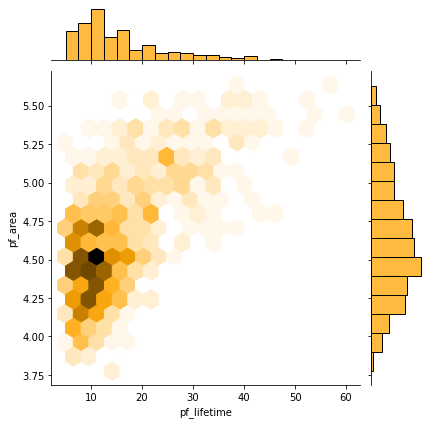

In [14]:
sns.jointplot(x=lifetime_land_obs, y=np.log10(pfarea_land_obs.max(dim='times')), kind="hex", color="orange")

In [15]:
# Set Seaborn plot style
sns.set_theme('talk', style='whitegrid', font_scale=1.3, 
              rc={'lines.linewidth':5, 'font.family':'Helvetica', 'axes.edgecolor':'k', 'grid.linestyle':'--'})
# sns.set_theme('talk', style='darkgrid', font_scale=1.3, rc={'lines.linewidth':5, 'font.family':'Helvetica'})

In [16]:
# def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_loc='lower right'):
#     mpl.rcParams['font.family'] = 'Helvetica'
#     g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

#     lcolors = {'obs':'steelblue', 'model':'darkorange'}
#     sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap='Blues', alpha=0.9, ax=g.ax_joint)
#     sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
#     sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
#     sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
#     sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
#     sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
#     legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
#                        mpl.lines.Line2D([0], [0], color=lcolors['model'])]
#     legend_labels = ['IMERG', 'WRF']
#     leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
#                             loc=legend_loc, facecolor='w', prop={'family':'Helvetica', 'size':18})
#     g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', transform=g.ax_joint.transAxes)
#     g.ax_joint.add_artist(leg)
#     g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
#     g.ax_marg_x.set_ylabel('')
#     g.ax_marg_y.set_xlabel('')

#     g.savefig(figname, dpi=300, facecolor='w')
#     # sns.JointGrid(marginal_ticks=True)
#     return g

In [17]:
def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_loc='lower right'):
    mpl.rcParams['font.family'] = 'Helvetica'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    legend_labels = ['IMERG', 'WRF']
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Helvetica', 'size':18})
    g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', fontsize=22, transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')

    g.savefig(figname, dpi=300, facecolor='w')
    # sns.JointGrid(marginal_ticks=True)
    return g

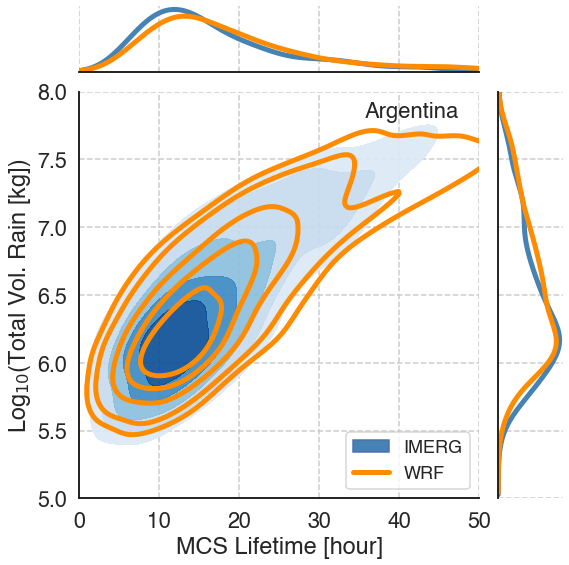

In [18]:
x_obs, y_obs = ccslifetime_land_obs.values, np.log10(pfvolrain_land_obs.sum(dim='times')).values
x_m1, y_m1 = ccslifetime_land_m1.values, np.log10(pfvolrain_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (0,50)
ylim = (5,8)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_imerg_wrf_{region}.png'
# figname
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)

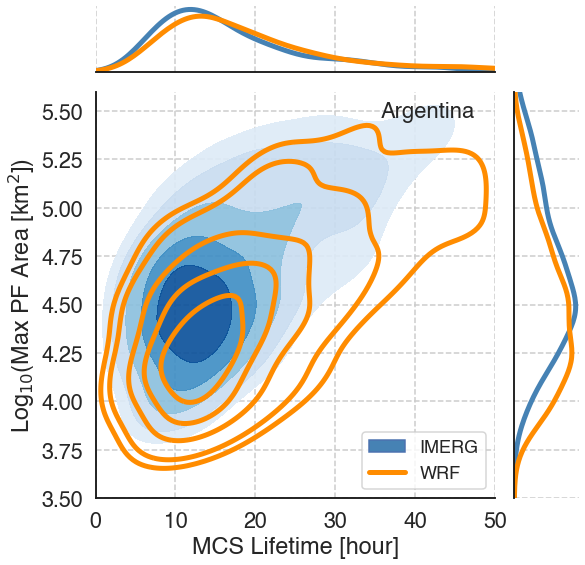

In [19]:
x_obs, y_obs = ccslifetime_land_obs.values, np.log10(pfarea_land_obs.max(dim='times')).values
x_m1, y_m1 = ccslifetime_land_m1.values, np.log10(pfarea_land_m1.max(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (0,50)
ylim = (3.5,5.6)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Max PF Area [km$^2$])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_Lifetime_PFarea_imerg_wrf_{region}.png'
# figname
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)

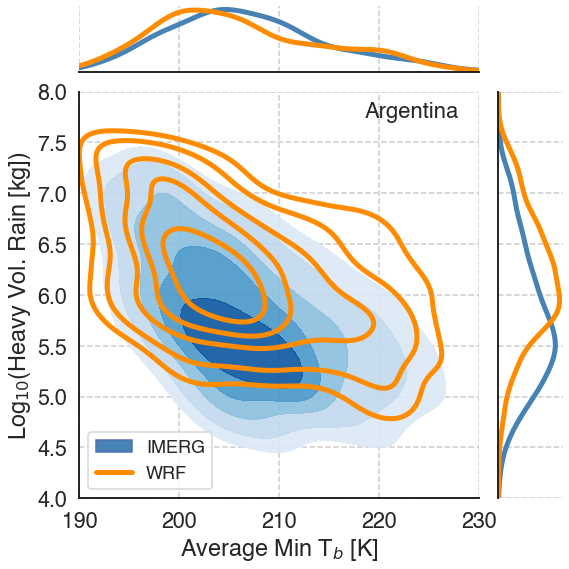

In [20]:
x_obs, y_obs = mintb_land_obs.mean(dim='times').values, np.log10(pfvolrainheavy_land_obs.sum(dim='times')).values
x_m1, y_m1 = mintb_land_m1.mean(dim='times').values, np.log10(pfvolrainheavy_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (190,230)
ylim = (4.,8)
xlabel = 'Average Min T$_b$ [K]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_MinTb_HeavyVolrain_imerg_wrf_{region}.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_loc='lower left')

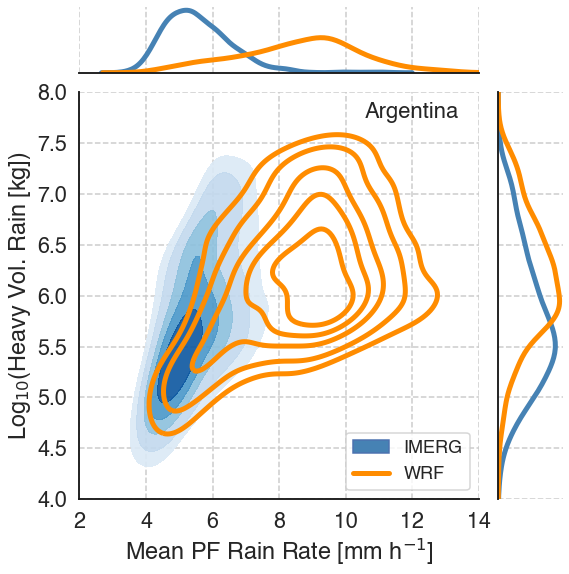

In [21]:
x_obs, y_obs = pfrainrate_land_obs.mean(dim='times').values, np.log10(pfvolrainheavy_land_obs.sum(dim='times')).values
x_m1, y_m1 = pfrainrate_land_m1.mean(dim='times').values, np.log10(pfvolrainheavy_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (2,14)
ylim = (4,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_PFrainrate_HeavyVolrain_imerg_wrf_{region}.png'
# figname
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)

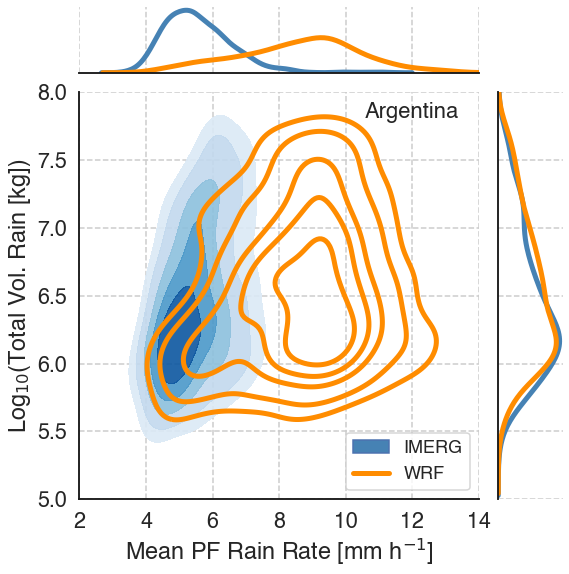

In [22]:
x_obs, y_obs = pfrainrate_land_obs.mean(dim='times').values, np.log10(pfvolrain_land_obs.sum(dim='times')).values
x_m1, y_m1 = pfrainrate_land_m1.mean(dim='times').values, np.log10(pfvolrain_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (2,14)
ylim = (5.,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_PFrainrate_TotalVolrain_imerg_wrf_{region}.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)